In [1]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import time
import glob
from astropy.visualization import PercentileInterval, ImageNormalize, AsinhStretch
from astropy.io import fits
import matplotlib.colors as mcolors


/home/msiudek/myspace/software/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-24 17:23:31.014637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740417811.029440  102378 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740417811.033661  102378 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 17:23:31.050437: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-cr

In [2]:
# Visualization function for embeddings
def visualize_embeddings_side_by_side(zss_2d_1, zss_2d_2, zss_2d_3, property_array_1, property_array_2, property_array_3,
                                      output_path=None):

    gridsize = 100
    categories = ['unknown','star', 'galaxy', 'qso']
    cmap = plt.cm.viridis  # Choose a color map
    norm = mcolors.BoundaryNorm(boundaries=np.arange(-1.5, 3), ncolors=cmap.N)

    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    fig = plt.figure(figsize=(22, 10)) 
    plt.subplots_adjust(left=0.1, bottom=None, right=None, top=None, wspace=0.02, hspace=0)

    # Helper function to add spines
    def add_spines(ax):
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1.5)  # You can adjust the line width here
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # Plot 1: VIS
    ax1 = fig.add_subplot(1, 3, 1)  
    scatter1 = ax1.hexbin(zss_2d_1[:, 0], zss_2d_1[:, 1], C=property_array_1, gridsize=gridsize, cmap=cmap, norm=norm)
    add_spines(ax1)  # Add spines to the plot
    ax1.text(0.8, 0.8, r'$\rm VIS$', transform=ax1.transAxes, fontsize=25, color='black')

    # Plot 2: VIS+NISP
    ax2 = fig.add_subplot(1, 3, 2)
    scatter2 = ax2.hexbin(zss_2d_2[:, 0], zss_2d_2[:, 1], C=property_array_2, gridsize=gridsize, cmap=cmap, norm=norm)
    add_spines(ax2)  # Add spines to the plot
    ax2.text(0.6, 0.8, r'$\rm VIS+NISP$', transform=ax2.transAxes, fontsize=25, color='black')

    # Plot 3: SED+VIS+NISP
    ax3 = fig.add_subplot(1, 3, 3)
    scatter3 = ax3.hexbin(zss_2d_3[:, 0], zss_2d_3[:, 1], C=property_array_3, gridsize=gridsize, cmap=cmap, norm=norm)
    add_spines(ax3)  # Add spines to the plot
    ax3.text(0.5, 0.8, r'$\rm VIS+NISP+SED$', transform=ax3.transAxes, fontsize=23, color='black')

    # Shared colorbar
    cbar = fig.colorbar(scatter2, ax=[ax1, ax2, ax3], orientation='vertical', fraction=0.02, pad=0.02, ticks=[-1, 0, 1, 2])
    cbar.ax.tick_params(labelsize=20)
    #cbar.set_label(f"{property_name}", fontsize=25)
    cbar.ax.set_yticklabels(categories)

    # Save or show
    if output_path:
        plt.savefig(output_path)
    else:
        plt.show()
    plt.close()


In [3]:
# Load the FITS catalog
def load_data(file):

    with fits.open(file) as hdul:
        catalog = hdul[1].data
    # Extract catalog properties
    object_ids = catalog['object_id']
    umap1 = catalog['UMAP1']
    umap2 = catalog['UMAP2']
    source_type = catalog['classification.Type']
    
    zss = np.column_stack((umap1, umap2))
    return zss, source_type

In [4]:
catalog_vis = "../../VIS/UMAP_VIS_train.fits"  
catalog_vis_nisp = "../../VIS_NISP/UMAP_VIS_NISP_train.fits"  
catalog_vis_nisp_sed = "../../VIS_NISP_SED/UMAP_VIS_NISP_SED_train.fits"  

In [5]:
zss_vis, source_type_vis = load_data(catalog_vis)


zss_vis_nisp, source_type_vis_nisp = load_data(catalog_vis_nisp)

zss_vis_nisp_sed, source_type_vis_nisp_sed = load_data(catalog_vis_nisp_sed)

In [6]:
print("Embeddings shape:", zss_vis.shape)
print("Embeddings shape:", zss_vis_nisp.shape)
print("Embeddings shape:", zss_vis_nisp_sed.shape)

Embeddings shape: (265407, 2)
Embeddings shape: (264800, 2)
Embeddings shape: (264800, 2)


In [7]:
# VIS
classification_array = np.array(source_type_vis, dtype=str)  # Ensure all elements are strings
classification_vis = np.zeros_like(classification_array, dtype=int)

classification_vis[classification_array == ''] = -1
classification_vis[classification_array == 'star'] = 2
classification_vis[classification_array == 'galaxy'] = 1
classification_vis[classification_array == 'qso'] = 3

In [8]:
# VIS_NISP
classification_array = np.array(source_type_vis_nisp, dtype=str)  # Ensure all elements are strings
classification_vis_nisp = np.zeros_like(classification_array, dtype=int)

classification_vis_nisp[classification_array == ''] = -1
classification_vis_nisp[classification_array == 'star'] = 2
classification_vis_nisp[classification_array == 'galaxy'] = 1
classification_vis_nisp[classification_array == 'qso'] = 3

In [9]:
print(np.unique(classification_vis_nisp))


[-1  1  2  3]


In [10]:
# VIS_NISP_SED
classification_array = np.array(source_type_vis_nisp_sed, dtype=str)  # Ensure all elements are strings
classification_vis_nisp_sed = np.zeros_like(classification_array, dtype=int)

classification_vis_nisp_sed[classification_array == ''] = -1
classification_vis_nisp_sed[classification_array == 'star'] = 2
classification_vis_nisp_sed[classification_array == 'galaxy'] = 1
classification_vis_nisp_sed[classification_array == 'qso'] = 3

## Classes

In [11]:
visualize_embeddings_side_by_side(zss_vis, zss_vis_nisp,zss_vis_nisp_sed,classification_vis,classification_vis_nisp,classification_vis_nisp_sed, output_path='class.png')

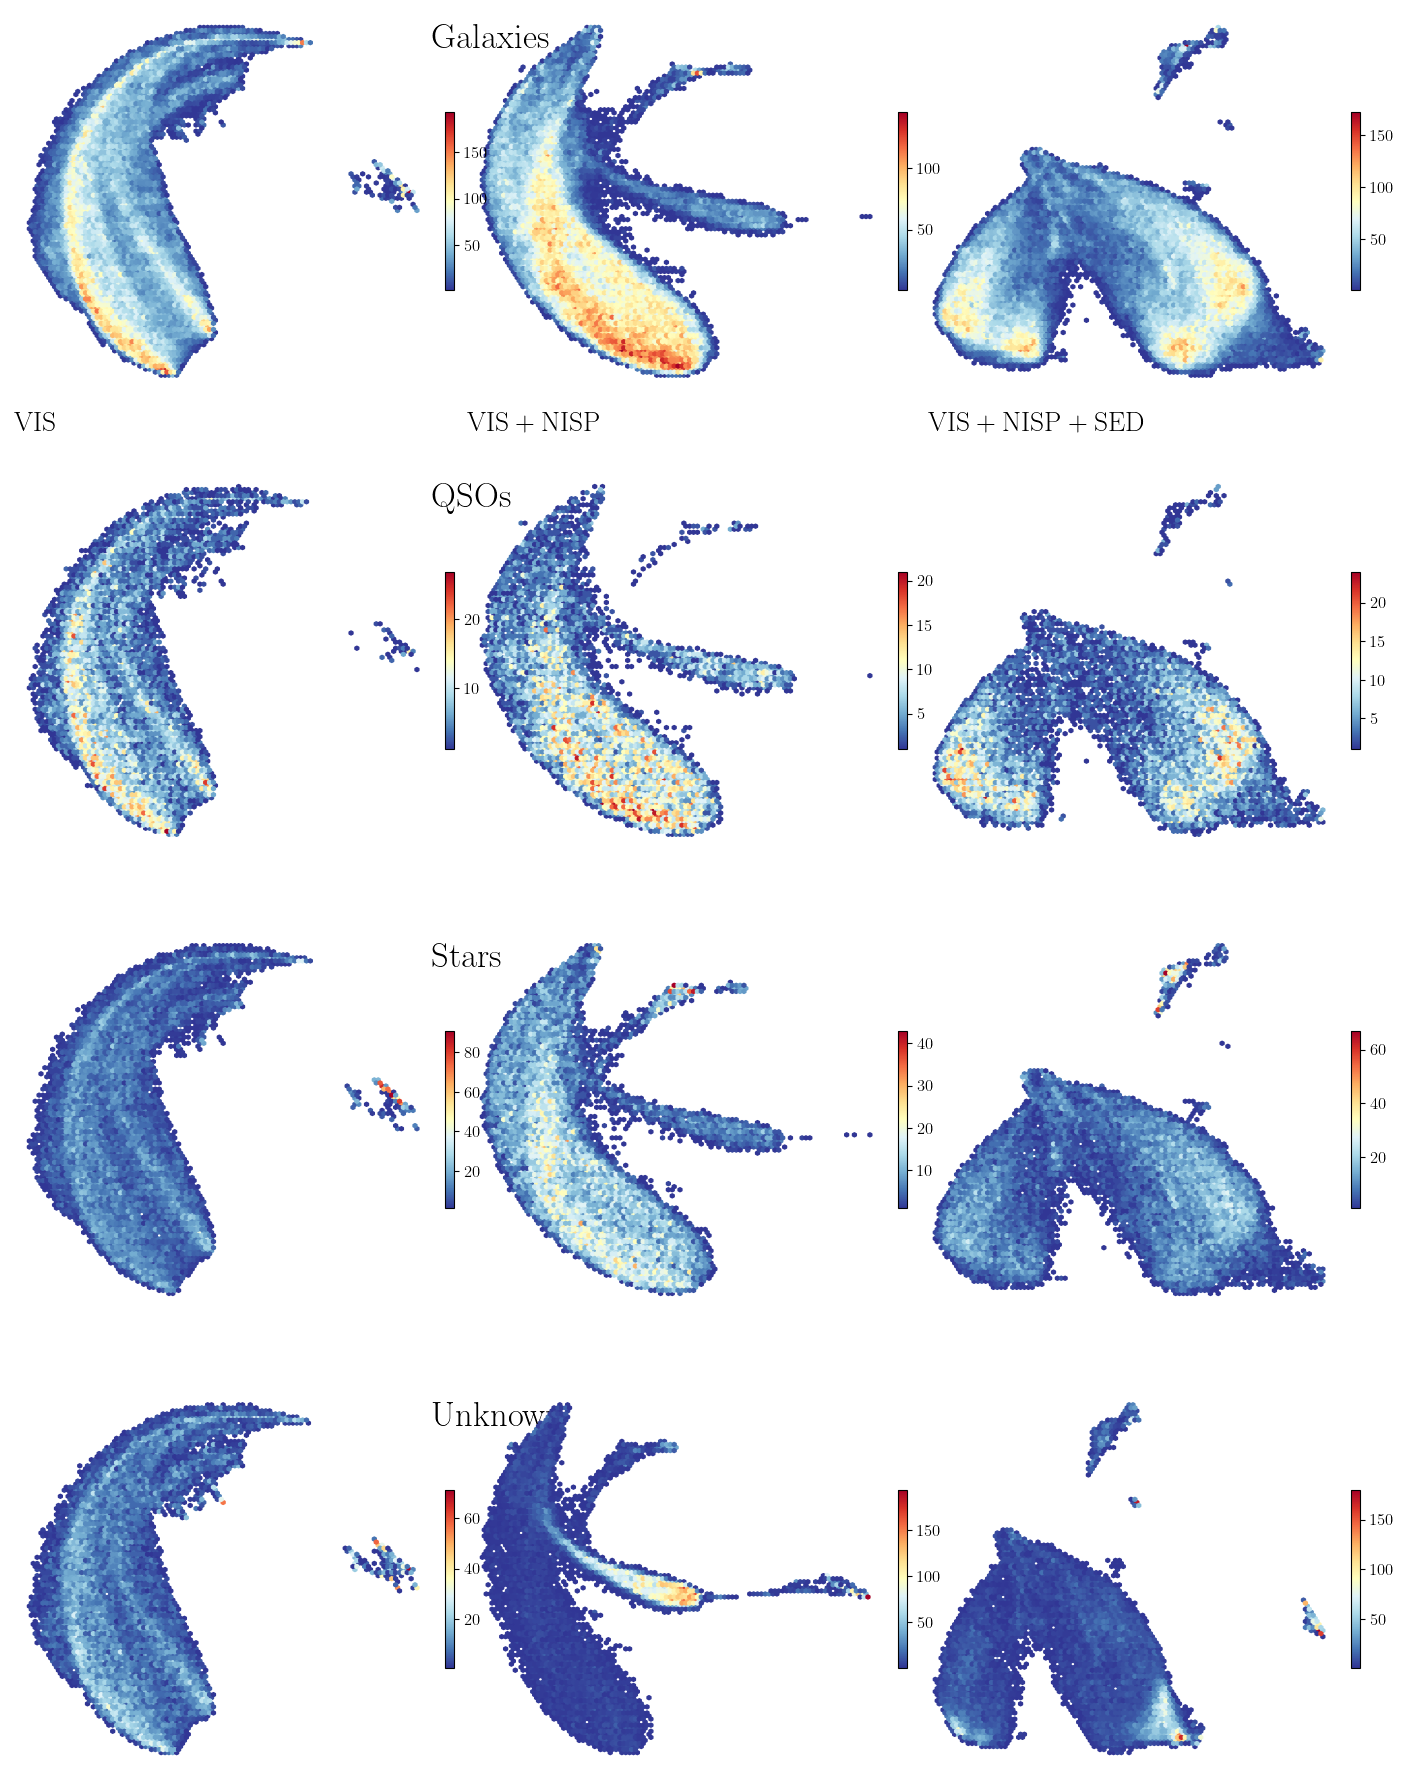

In [24]:
# Parameters for the plot
gridsize = 100  
cmap = "RdYlBu_r"  # Chosen color map (reversed)

# Set background color to white
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Set figure size and layout (4 rows and 3 columns)
fig, axes = plt.subplots(4, 3, figsize=(15, 20))
plt.subplots_adjust(left=0.08, bottom=0.07, right=0.98, top=0.95, wspace=0.02, hspace=0.2)

# Categories
categories = ['galaxy', 'qso', 'star', 'unknown']
category_labels = ['Galaxies', 'QSOs', 'Stars', 'Unknown']

# Create a dictionary for the masks and data arrays for each category
category_data = {
    'galaxy': (classification_vis == 1, classification_vis_nisp == 1, classification_vis_nisp_sed == 1),
    'qso': (classification_vis == 3, classification_vis_nisp == 3, classification_vis_nisp_sed == 3),
    'star': (classification_vis == 2, classification_vis_nisp == 2, classification_vis_nisp_sed == 2),
    'unknown': (classification_vis == -1, classification_vis_nisp == -1, classification_vis_nisp_sed == -1)
}

# Loop over the categories and create the hexbin plots
for i, (category, (mask_vis, mask_vis_nisp,mask_vis_nisp_sed)) in enumerate(category_data.items()):
    # Select data based on the category mask
    zss_vis_category = zss_vis[mask_vis]
    zss_vis_nisp_category = zss_vis_nisp[mask_vis_nisp]
    zss_vis_nisp_sed_category = zss_vis_nisp_sed[mask_vis_nisp_sed]

    # Plot for VIS
    ax1 = axes[i, 0]  # Left column
    if zss_vis_category.size > 0:
        hb1 = ax1.hexbin(zss_vis_category[:, 0], zss_vis_category[:, 1],
                         gridsize=gridsize, cmap=cmap, mincnt=1)
    if i == 0:
        ax1.text(0.01, -0.1, r'$\rm VIS$', transform=ax1.transAxes, fontsize=20, color='black')
    ax1.text(0.99, 0.9, f'{category_labels[i]}', transform=ax1.transAxes, fontsize=25, color='black')

    # Remove axis labels and ticks
    ax1.axis('off')
    ax1.minorticks_on()

    # Add colorbar to the left plots (VIS) inside the plot
    cbar = fig.colorbar(hb1, ax=ax1, orientation='vertical', fraction=0.02, pad=0.02)
    cbar.ax.tick_params(labelsize=12)

    # Plot for VIS+NISP
    ax2 = axes[i, 1]  # Middle column
    if zss_vis_nisp_category.size > 0:
        hb2 = ax2.hexbin(zss_vis_nisp_category[:, 0], zss_vis_nisp_category[:, 1],
                         gridsize=gridsize, cmap=cmap, mincnt=1)
    if i ==0:
        ax2.text(0.01, -0.1, r'$\rm VIS+NISP$', transform=ax2.transAxes, fontsize=20, color='black')
    #ax2.text(0.6, 0.1, f'{category_labels[i]}', transform=ax2.transAxes, fontsize=25, color='black')

    # Remove axis labels and ticks
    ax2.axis('off')
    ax2.minorticks_on()

    # Add colorbar to the right plots (VIS+NISP) inside the plot
    cbar = fig.colorbar(hb2, ax=ax2, orientation='vertical', fraction=0.02, pad=0.02)
    cbar.ax.tick_params(labelsize=12)

    # Plot for VIS+NISP+SED
    ax3 = axes[i, 2]  # Right column
    if zss_vis_nisp_sed_category.size > 0:
        hb3 = ax3.hexbin(zss_vis_nisp_sed_category[:, 0], zss_vis_nisp_sed_category[:, 1],
                         gridsize=gridsize, cmap=cmap, mincnt=1)
    if i ==0:
        ax3.text(1.09, -0.1, r'$\rm VIS+NISP+SED$', transform=ax2.transAxes, fontsize=20, color='black')
    #ax2.text(0.6, 0.1, f'{category_labels[i]}', transform=ax2.transAxes, fontsize=25, color='black')

    # Remove axis labels and ticks
    ax3.axis('off')
    ax3.minorticks_on()

    # Add colorbar to the right plots (VIS+NISP) inside the plot
    cbar = fig.colorbar(hb3, ax=ax3, orientation='vertical', fraction=0.02, pad=0.02)
    cbar.ax.tick_params(labelsize=12)
plt.savefig("class_detailed.png")
plt.show()
